In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports Libraries and Tools

In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


Load Datasets

In [ ]:
# PARAMETERS
IMAGE_SIZE = 224
BATCH_SIZE = 20
EPOCHS = 10

# CLASS LABELS (Consistent order)
train_dir = '/content/drive/MyDrive/MRI images/Training'
test_dir = '/content/drive/MyDrive/MRI images/Testing'
class_labels = sorted(os.listdir(train_dir))

# LOAD DATA
def load_data(directory):
    paths, labels = [], []
    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_name in os.listdir(class_path):
            paths.append(os.path.join(class_path, img_name))
            labels.append(label)
    return shuffle(paths, labels)

train_paths, train_labels = load_data(train_dir)
test_paths, test_labels = load_data(test_dir)


Data Visualization

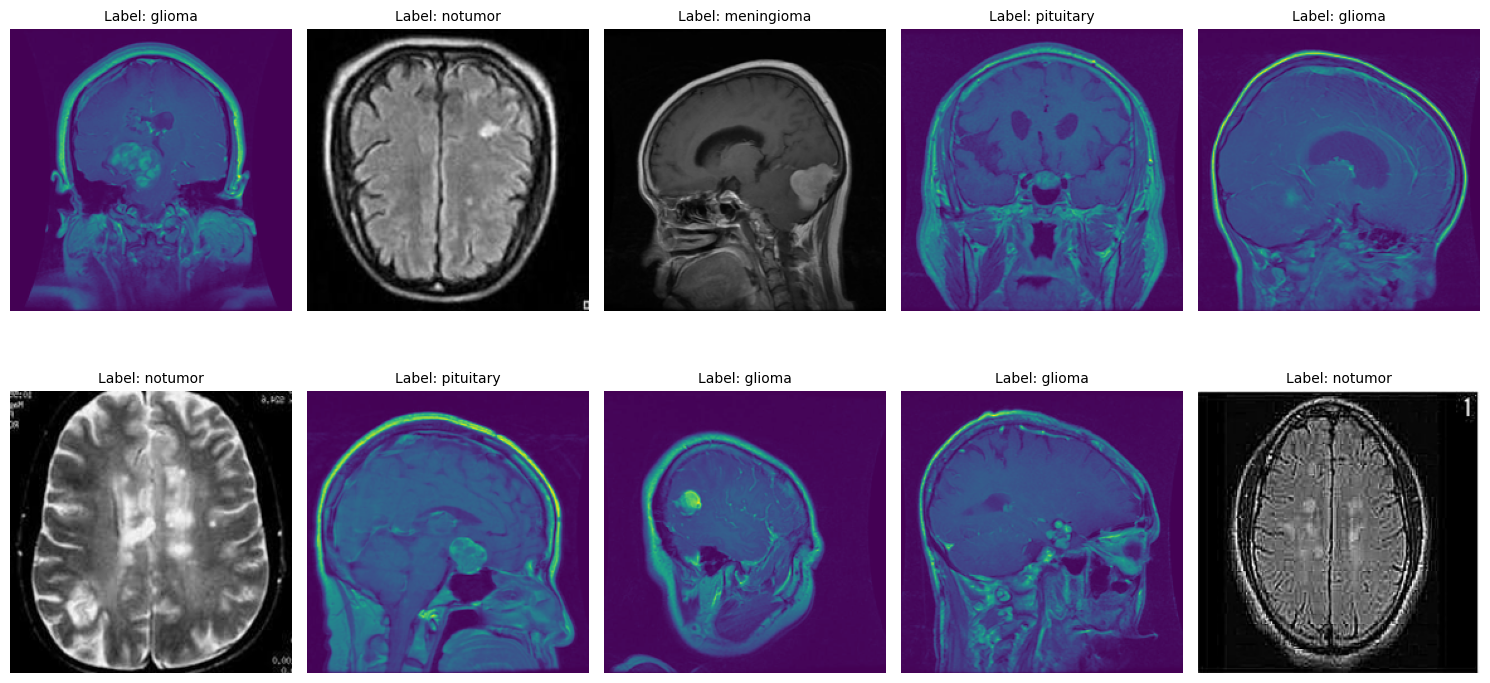

In [ ]:
###Visualize Sample Images
def visualize_samples(paths, labels):
    indices = random.sample(range(len(paths)), 10)
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.ravel()
    for i, idx in enumerate(indices):
        img = Image.open(paths[idx]).resize((224, 224))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {labels[idx]}", fontsize=10)
    plt.tight_layout()
    plt.show()

visualize_samples(train_paths, train_labels)


Image Preprocessing (Helper Functions)

In [ ]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image)
    return image

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = img_to_array(image)
        image = augment_image(image)
        image = preprocess_input(image)  # VGG16 specific preprocessing
        images.append(image)
    return np.array(images)

def encode_labels(labels):
    return np.array([class_labels.index(label) for label in labels])

def datagen(paths, labels, batch_size=16, epochs=2):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            yield open_images(batch_paths), encode_labels(batch_labels)


In [ ]:
#Model architecture
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

# Fine-tune last layers
for layer in base_model.layers[-3:]:
    layer.trainable = True

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])


In [ ]:
#Train model
steps = len(train_paths) // BATCH_SIZE
history = model.fit(datagen(train_paths, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS),
                    epochs=EPOCHS, steps_per_epoch=steps)


Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - loss: 1.6984 - sparse_categorical_accuracy: 0.7299
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 61s 180ms/step - loss: 0.2785 - sparse_categorical_accuracy: 0.9018
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 48s 167ms/step - loss: 0.1882 - sparse_categorical_accuracy: 0.9333
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 48s 169ms/step - loss: 0.1387 - sparse_categorical_accuracy: 0.9503
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 47s 165ms/step - loss: 0.0995 - sparse_categorical_accuracy: 0.9659
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 47s 165ms/step - loss: 0.0705 - sparse_categorical_accuracy: 0.9773
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 43s 153ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.9703
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 46s 160ms/step - loss: 0.0919 - sparse_categorical_accuracy: 0.9718
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 43s 152ms/step - loss: 0.0330 - sparse_categorical_accuracy: 0.9891
Epoch 10/10
285/285 ━━━━━━━━

Plot Training History

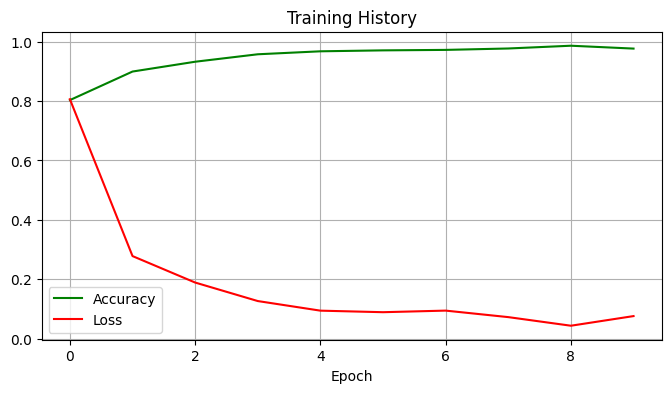

In [ ]:
#Plot traning  History
plt.figure(figsize=(8,4))
plt.plot(history.history['sparse_categorical_accuracy'], 'g-', label='Accuracy')
plt.plot(history.history['loss'], 'r-', label='Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()


Evaluate Model

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 507ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.88      0.93       300
  meningioma       0.90      0.93      0.92       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.94      1.00      0.97       300

    accuracy                           0.96      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



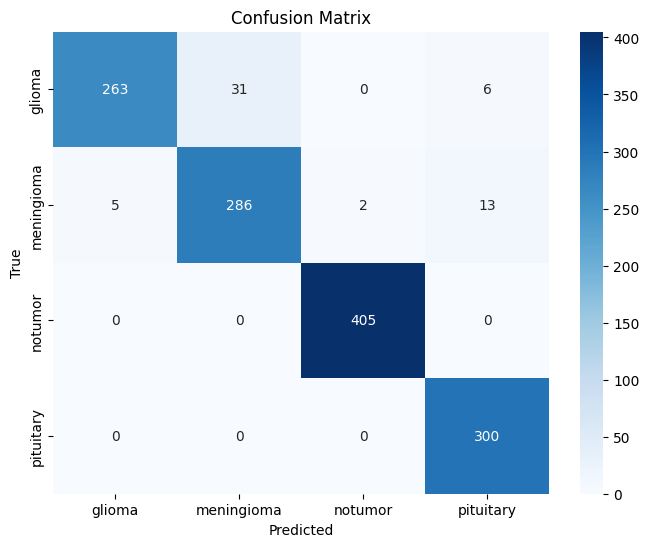

In [ ]:
#Evaluate Model
test_images = open_images(test_paths)
test_encoded = encode_labels(test_labels)
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# CLASSIFICATION REPORT
print("Classification Report:")
print(classification_report(test_encoded, predicted_classes, target_names=class_labels))

# CONFUSION MATRIX
conf_matrix = confusion_matrix(test_encoded, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Roc Curve Plot

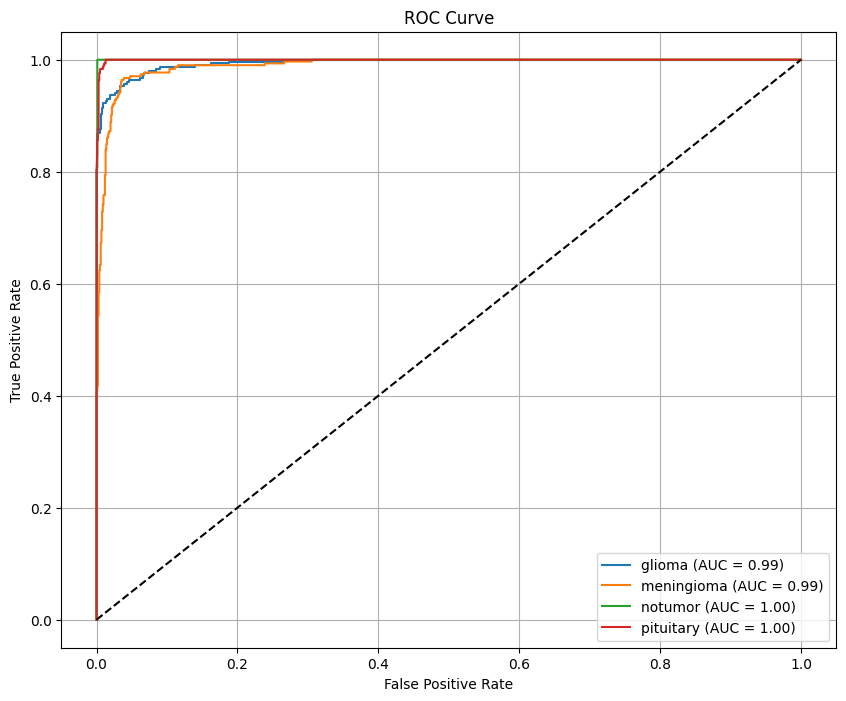

In [ ]:
test_bin = label_binarize(test_encoded, classes=np.arange(len(class_labels)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(test_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Prediction Function


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


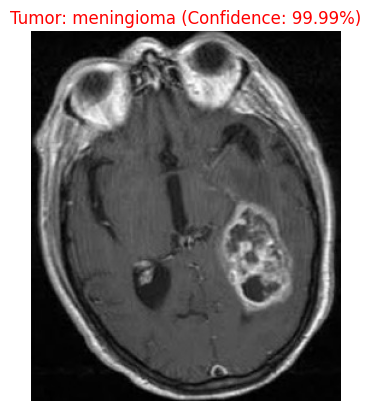

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


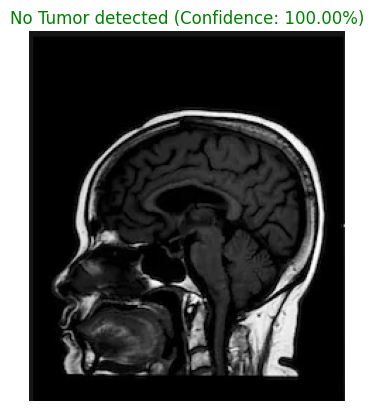

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


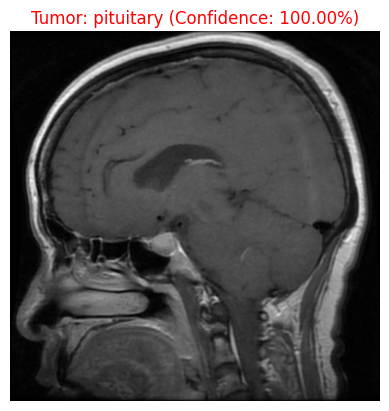

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


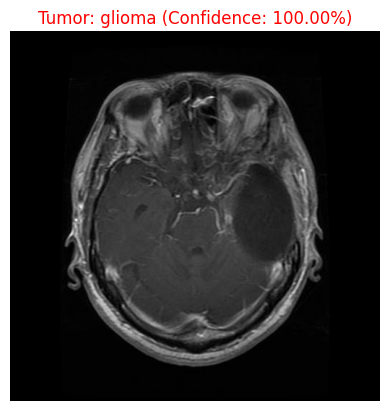

In [ ]:
def detect_and_display(img_path, model, image_size=224):
    try:
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = preprocess_input(img_array * 255.0)
        img_array = np.expand_dims(img_array, axis=0)

        preds = model.predict(img_array)
        idx = np.argmax(preds[0])
        conf = np.max(preds[0])

        result = "No Tumor detected" if class_labels[idx] == 'notumor' else f"Tumor: {class_labels[idx]}"
        color = 'green' if class_labels[idx] == 'notumor' else 'red'

        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {conf * 100:.2f}%)", color=color)
        plt.show()

    except Exception as e:
        print("Error:", e)

# EXAMPLES
detect_and_display('/content/drive/MyDrive/MRI images/Testing/meningioma/Te-meTr_0001.jpg', model)
detect_and_display('/content/drive/MyDrive/MRI images/Testing/notumor/Te-noTr_0004.jpg', model)
detect_and_display('/content/drive/MyDrive/MRI images/Testing/pituitary/Te-piTr_0003.jpg', model)
detect_and_display('/content/drive/MyDrive/MRI images/Testing/glioma/Te-gl_0015.jpg', model)


In [ ]:
# Save the entire model
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')